Following on from Part 2 of MakeMore, this notebook looks at further optimising the code and learning more about the activations, gradients and batchnorm.

In [37]:
# Import libraries
import os
import random
from striprtf.striprtf import rtf_to_text
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn import functional as F

In [94]:
# Block containing all the hyperparameters
block_size = 5 # Number of characters/tokens to be processed in the model
batch_size = 64 # Number of blocks to be processed in parallel
max_iters = 100000 # Num of iterations to train the model
learning_rate = 0.1 # Learning rate 
n_embd = 10 # Num of dimensions in the embedding layer
eps = 1e-5 # Small value to avoid division by 0 during batch normalization

# Num of inputs to the hidden layer
n_in = block_size * n_embd # Bexcause we have n_embd dimensional embeddings and we have 5 (block size) of them
n_hidden = 200 # Num of neurons in the hidden layer. We can take any number we want. We are starting with 128
n_biases = n_hidden # Num of biases in the hidden layer. Keeping 1 bias for each neuron

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # For M1 Mac

torch.manual_seed(42)
g = torch.Generator(device=device).manual_seed(42) # For reproducibility

In [39]:
# Import input text file and read it line by line
in_filepath = os.getcwd() + "/data/in/MakeMore/"
with open(in_filepath+'input.rtf', 'r', encoding='utf-8') as f:
    rtf = f.read()

# Convert RTF to text
text = rtf_to_text(rtf)

# Split text as a list
words = text.splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

## Part 1: Building the neural net

In [40]:
# First, we create a simple vocabulary/ lookup table that maps each character to an integer and vice versa. 
chars = sorted(list(set(''.join(words))))

# Create a simple iterator to convert the characters in our input text to integers and vice versa.
stoi = {s:i+1 for i,s in enumerate(chars)}

# Add indexes for the start and end tokens
stoi['.'] = 0

# Create an inverse dictionary to convert the integers back to characters
itos = {i:s for s,i in stoi.items()}

# Get total num of chars. This will be used heavily later
num_chars = len(stoi)

In [50]:
# ---- Common functions ----


# Function to build the dataset
def build_dataset(words, block_size):
    # Initialize the input and output sequences
    X, Y = [], []

    # Create rolling windows of the input text to create the context and target sequences
    for w in words:
        #print(w)
        context = block_size * [0]
        
        for ch in w + '.':
            # Get the integer representation of the character
            ix = stoi[ch]

            # Add the integer to the input sequence
            X.append(context.copy())

            # Add the integer to the output sequence
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '-->', itos[ix])
            context = context[1:] + [ix] # Crop and append

    # Convert to tensors
    X = torch.tensor(X, dtype=torch.long, device=device)
    Y = torch.tensor(Y, dtype=torch.long, device=device)
    print(f'X shape: {X.shape}, Y shape: {Y.shape}')

    # Return the input and output sequences
    return X, Y


# Function to reinitialize the weights and biases
def reinitialize_weights_old(num_chars, n_embd, n_in, n_hidden, n_biases):
    
    g = torch.Generator(device=device).manual_seed(42) # For reproducibility
    C = torch.randn((num_chars, n_embd), device=device, generator=g) # We use 2 because we just have 27 characters to deal with

    # Create a random set of weights for the hidden layer
    W1 = torch.randn((n_in, n_hidden), device=device, generator=g)
    B1 = torch.randn((n_biases), device=device, generator=g) * 0 # Multiply by 0 to initialize the biases to 0 instead of random values (reason below)

    # Create a random set of weights for the output layer
    # FIX 1: Even without training a model, we can come up with a high level prediction of what the loss in the first iteration should be. There are 27 characters in our case. 
    # Without model training, the probability of getting any 1 of them is 1/27. Hence, the loss can be calculated as -log(1/27) = 3.2958. 
    # The reason this is important to understand is that there is a probability the logits in the forward pass could have extreme values which could lead to inconsistent 
    # losses (could be very small or very large). As a result, we would want the logits to be roughly 0 when the network is initialised. To do this, we could potentially do 2 things:
    #    - convert the input bias term to 0 for the first iteration.
    #    - reduce the scale of weight term. While it could work, the recommendation is to NOT set weights to exact 0
    # What we expect to see by doing that is that the hockey stick shape of the loss function is improve where the network is essentially squashing the extreme values of the logits resulting in high loss terms. We can do that beforehand and let the network do the hard yards.
    W2 = torch.randn((n_hidden, num_chars), device=device, generator=g) * 0.1 # Multiply by 0.1 to reduce the scale of the weights
    B2 = torch.randn((num_chars), device=device, generator=g) * 0 # Multiply by 0 to initialize the biases to 0 instead of random values

    # Create an array to store the loss values
    params = [C, W1, B1, W2, B2]
    for param in params:
        param.requires_grad = True # For params, set requires_grad to True (very important for the model training)

    return params



#### Create training, validation and test splits

In [42]:
# Shuffle the words randomly
random.seed(42) # For reproducibility
random.shuffle(words)

# Split pointers
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# Create the train, validation and test sets
X_train, Y_train = build_dataset(words[:n1], block_size)
X_val, Y_val = build_dataset(words[n1:n2], block_size)
X_test, Y_test = build_dataset(words[n2:], block_size)

X shape: torch.Size([182625, 5]), Y shape: torch.Size([182625])
X shape: torch.Size([22655, 5]), Y shape: torch.Size([22655])
X shape: torch.Size([22866, 5]), Y shape: torch.Size([22866])


#### Change #1: Addressing the initial loss by adjusting weights and biases at initialisation

In [43]:
# ---- Model Functions ----

# Create a function to calculate the loss and update the parameters (this has been updated during model improvement)
def optimise_training_parameters_old(params, iters, lr_decay=False):
    # Create an array to store the loss values
    stepi = []
    lossi = []
    
    # Get weights and biases
    C = params[0]; W1 = params[1]; B1 = params[2]; W2 = params[3]; B2 = params[4]

    # Calculate the gradients
    for i in range(iters):

        # Create a mini batch
        # We do that by randomly selecting a batch size number of indices from the X tensor. We then use those indices to get the corresponding values from the X and Y tensors
        # For example, if the batch size is 4 and the X tensor has 10 rows, then we will randomly select 4 indices from the X tensor. Let's say the indices are 2, 4, 6 and 8 (indices start from 0) 
        # Then we will use those indices to get the corresponding values from the X and Y tensors. For example, X[2] will give us the 3rd row of the X tensor and Y[2] will give us the 3rd row of the Y tensor
        # We will repeat this process for the entire batch size. We will then use the mini batch to calculate the loss and update the parameters
        batch_indexes = torch.randint(0, X_train.shape[0], (batch_size,), device=device)

        # Forward pass
        emb = C[X_train[batch_indexes]]
        emb_reshaped = emb.view(emb.shape[0], emb.shape[1] * emb.shape[2])
        h = emb_reshaped @ W1 + B1 # Hidden layer pre activation
        h = torch.tanh(h)
        logits = h @ W2 + B2
        loss = F.cross_entropy(logits, Y_train[batch_indexes])

        # Backward pass
        for p in params:
            p.grad = None
        loss.backward()

        # Update the parameters
        if (i > max_iters * 0.8) & lr_decay==True: 
            lr=learning_rate*0.1 
        else: 
            lr=learning_rate
        for p in params:
            p.data -= lr * p.grad
        
        # Track stats
        stepi.append(i)
        lossi.append(loss.log10().item())

    # Print training loss
    print(f'Loss after training {iters} iters = {loss}\n')

    # Return the loss values
    return stepi, lossi, params


# Calculate the loss on any complete dataset
def model_loss_old(params, X, Y):
    # Disable gradient tracking
    # @torch.no_grad() is a Python decorator provided by PyTorch that can be used to temporarily disable gradient computation, which can save memory and computation time. 
    # When you apply this decorator to a function or a code block, any computation that involves gradients will not be tracked by PyTorch's autograd system, and no new 
    # computational graph nodes will be created. This can be useful in scenarios where you want to perform some computation without building up gradients in order to avoid 
    # memory overflow, or when you want to do inference on a pre-trained model without updating its parameters.
    with torch.no_grad():
        # Get weights and biases
        C = params[0]; W1 = params[1]; B1 = params[2]; W2 = params[3]; B2 = params[4]
        
        emb = C[X]
        emb_reshaped = emb.view(emb.shape[0], emb.shape[1] * emb.shape[2])
        h = emb_reshaped @ W1 + B1
        h = torch.tanh(h)
        logits = h @ W2 + B2
        loss = F.cross_entropy(logits, Y)
    return loss


# Generate sample output
def generate_output_samples_old(num_samples, params):
    # Get weights and biases
    C = params[0]; W1 = params[1]; B1 = params[2]; W2 = params[3]; B2 = params[4]    
    
    for _ in range(num_samples):
        out = []
        context = block_size * [0]
        while True:
            emb = torch.tensor(C[context]) # 1 x block_size x dim
            emb_reshaped = emb.view(1, -1)
            h = emb_reshaped @ W1 + B1
            h = torch.tanh(h)
            logits = h @ W2 + B2
            probs = F.softmax(logits, dim=1)
            next_char = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [next_char]
            out.append(next_char)
            if next_char == 0:
                break
        print(''.join([itos[i] for i in out]))



In [44]:
# Create the parameters
params = reinitialize_weights_old(num_chars=num_chars,n_embd=n_embd, n_in=n_in, n_hidden=n_hidden, n_biases=n_biases)

# Train the model - Update the parameters
stepi, lossi, tuned_params = optimise_training_parameters_old(params, max_iters, lr_decay=True)

# Print the loss on the entire train set
print(f'Loss on train set = {model_loss_old(tuned_params, X_train, Y_train)}')

# Print the loss on the entire validation set
print(f'Loss on validation set = {model_loss_old(tuned_params, X_val, Y_val)}')


Loss after training 100000 iters = 2.093675136566162

Loss on train set = 2.0428004264831543
Loss on validation set = 2.1261072158813477


In [45]:
# Print the loss a few times
n_print = max_iters // 20 # Print every 5% of the iterations
for i in range(0, max_iters, n_print):
    print(f'Loss after {i} iters = {lossi[i]}')

Loss after 0 iters = 0.6024281978607178
Loss after 5000 iters = 0.3714485764503479
Loss after 10000 iters = 0.3490031659603119
Loss after 15000 iters = 0.32091107964515686
Loss after 20000 iters = 0.36223867535591125
Loss after 25000 iters = 0.3226796090602875
Loss after 30000 iters = 0.30926963686943054
Loss after 35000 iters = 0.3747977912425995
Loss after 40000 iters = 0.3455289304256439
Loss after 45000 iters = 0.34365105628967285
Loss after 50000 iters = 0.33714285492897034
Loss after 55000 iters = 0.31563836336135864
Loss after 60000 iters = 0.2924589216709137
Loss after 65000 iters = 0.33895987272262573
Loss after 70000 iters = 0.3432464599609375
Loss after 75000 iters = 0.2723974287509918
Loss after 80000 iters = 0.31959882378578186
Loss after 85000 iters = 0.2948800027370453
Loss after 90000 iters = 0.31168219447135925
Loss after 95000 iters = 0.32961806654930115


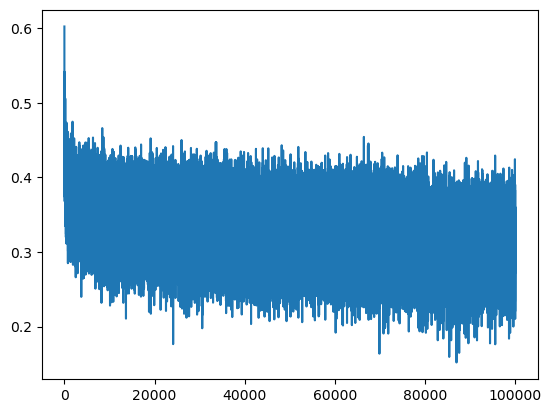

In [48]:
# We can not see that due to the wight W2 and bias B2 being initialised differently, the is (mostly) not a hockey stick shape in the loss curve. The loss curve is much smoother and the loss is much lower
plt.plot(stepi, lossi)

In [49]:
# Generate samples based on the trained model
generate_output_samples_old(10, tuned_params)

/var/folders/pj/3fn1xxdn4cz7gfp1g7pnb3dm0000gn/T/ipykernel_26165/335505260.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(C[context]) # 1 x block_size x dim


garey.
calleig.
dasion.
bennorea.
olan.
demurdne.
jhial.
pheyn.
zyna.
caivoe.


#### Change #2: Tanh activation - addressing the extreme values of the activation function

If we look at the values of h in the forward pass, we would find that a lot of values have the vlaue 1.0000 and -1.0000. Tanh function squashes random numbers smoothly between -1 and 1. As a result, many extreme values get assigned those extreme values giving a distribution like

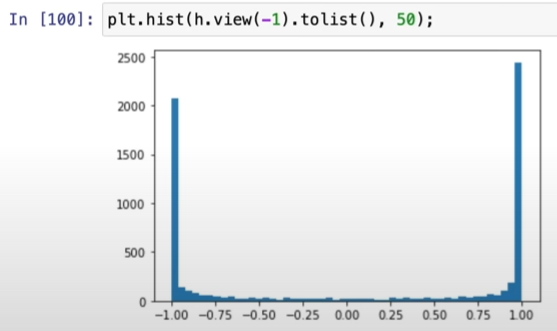

The effect of this is seen during backpropagation. We know that the gradient is calculated using the formula

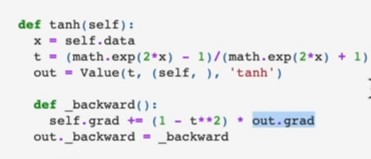

If a large number of tanh (t) values are -1 and 1, the gradient will become 0 due to (1-t**2) in the gradient formula, irrespective of the out.grad value.To address this, we can take the hidden layer prectivation step and reduce the range of the output. If we see the forward pass we can see that this step is achieved as 

    => h = X @ W

We know that X (or word embedding C[X]) is unit guassian  with mean ~ 0 amd std ~ 1.0. However, this is not the case with W, since it has been randomly created with torch.rand. To ensure that the product of the 2 terms is also std ~ 1.0, we can simply divide the initial weight by a term called 'fan_in' that is the number of neurons ** 0.5

    => fan_in = W.shape[0]**0.5

In addition, there is also a gain factor (kaiming initialisation paper) which should be multiplied - https://pytorch.org/docs/stable/nn.init.html. For tanh, it is 5/3. 

In [56]:
# Rewrite the function to initialise the weights

# Function to reinitialize the weights and biases
def reinitialize_weights_old2(num_chars, n_embd, n_in, n_hidden, n_biases):
    
    g = torch.Generator(device=device).manual_seed(42) # For reproducibility
    C = torch.randn((num_chars, n_embd), device=device, generator=g) # We use 2 because we just have 27 characters to deal with

    # Create a random set of weights for the hidden layer
    W1 = torch.randn((n_in, n_hidden), device=device, generator=g) * (5/3) / (n_in**0.5) # Kaiming He initialization
    B1 = torch.randn((n_biases), device=device, generator=g) * 0 # Multiply by 0 to initialize the biases to 0 instead of random values (reason below)

    # Create a random set of weights for the output layer
    W2 = torch.randn((n_hidden, num_chars), device=device, generator=g) * (5/3) / (n_hidden**0.5) # Kaiming He initialization
    B2 = torch.randn((num_chars), device=device, generator=g) * 0 # Multiply by 0 to initialize the biases to 0 instead of random values

    # Create an array to store the loss values
    params = [C, W1, B1, W2, B2]
    for param in params:
        param.requires_grad = True # For params, set requires_grad to True (very important for the model training)

    return params

In [57]:
# Create the parameters
params = reinitialize_weights_old2(num_chars=num_chars,n_embd=n_embd, n_in=n_in, n_hidden=n_hidden, n_biases=n_biases)

# Train the model - Update the parameters
stepi, lossi, tuned_params = optimise_training_parameters_old(params, max_iters, lr_decay=True)

# Print the loss on the entire train set
print(f'Loss on train set = {model_loss_old(tuned_params, X_train, Y_train)}')

# Print the loss on the entire validation set
print(f'Loss on validation set = {model_loss_old(tuned_params, X_val, Y_val)}')


Loss after training 100000 iters = 1.741316795349121

Loss on train set = 1.9340291023254395
Loss on validation set = 2.053123712539673


In [58]:
# Generate samples based on the trained model
generate_output_samples_old(10, tuned_params)

/var/folders/pj/3fn1xxdn4cz7gfp1g7pnb3dm0000gn/T/ipykernel_26165/335505260.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(C[context]) # 1 x block_size x dim


gaeryc.
eliopa.
jalani.
ronarae.
leontrell.
alysyan.
zaynley.
tylath.
bayleigh.
addon.


####  Change #3: BatchNorm

Ideally, at the time of initialisation, what we would want is to have the pre-activation state normally distributed. We also dont want it to be too high or too low (due to tanh function assigning -1 or 1). Essentially what we can do is to standardise hidden states to make them gaussian and that is a differentiable operation. (Source: https://arxiv.org/pdf/1502.03167.pdf, paper titled: 'Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift')

In [100]:

# Rewrite the function to initialise the weights for batch normalization
# Function to reinitialize the weights and biases
def reinitialize_weights(num_chars, n_embd, n_in, n_hidden): # We removed the n_biases parameter as we do not need it anymore for B1
    
    g = torch.Generator(device=device).manual_seed(42) # For reproducibility
    C = torch.randn((num_chars, n_embd), device=device, generator=g) # We use 2 because we just have 27 characters to deal with

    # Create a random set of weights for the hidden layer
    W1 = torch.randn((n_in, n_hidden), device=device, generator=g) * (5/3) / (n_in**0.5) # Kaiming He initialization
    # B1 = torch.randn((n_biases), device=device, generator=g) * 0 # Commented out because we do not need to initialize the biases
    # Since we are using batch normalization, we do not need to initialize the biases. When we do batch norm, we are subtracting the prenorm mean making the bias redundant
    # We can simply remove bias from the model wherever it is present before the batch norm layer. In this case, it is B1 that can be removed.

    # Create a random set of weights for the output layer
    W2 = torch.randn((n_hidden, num_chars), device=device, generator=g) * (5/3) / (n_hidden**0.5) # Kaiming He initialization
    B2 = torch.randn((num_chars), device=device, generator=g) * 0 # Multiply by 0 to initialize the biases to 0 instead of random values

    # Create parameters for batch normalization
    gamma = torch.ones((1, n_hidden), device=device)
    beta = torch.zeros((1, n_hidden), device=device)    

    # Create an array to store the loss values
    params = [C, W1, W2, B2, gamma, beta] # We commented out B1 and added gamma and beta
    for param in params:
        param.requires_grad = True # For params, set requires_grad to True (very important for the model training)

    return params


# Function to implement batch normalization
# This is to ensure that every single neuron in the batch is now going to be unit gaussian when fired
# However, we also want to ensure that neurons are not 'perfectly unit gaussian' and have the ability to change a bit as per the backpropagation
# To do this, we add a gain and bias term to the batch normalization
def batch_norm(prenorm, gamma, beta, batch_running_mean, batch_running_std):
    # Calculate the mean of the prenorm
    mean = prenorm.mean(0, keepdim=True)

    # Calculate the standard deviation of the prenorm
    std = prenorm.std(0, keepdim=True)

    # Apply the batch normalization
    bn = (prenorm - mean) / (std+eps) # Normalise

    # Add the gain and bias term
    bn = bn * gamma + beta # Scale and shift

    # Update the running mean and std without keeping track of the gradients
    with torch.no_grad():
        # Update the running mean and std
        batch_running_mean = batch_running_mean * 0.999 + mean * 0.001 # 0.001 is the same as momentum. Typically, momentum is 0.1 in batchnorm in pytorch. 
        # cont.. While its ok for big batches, but for small batches, we need to use a smaller momentum so that we can arrive at the correct mean and std of the training set
        batch_running_std = batch_running_std * 0.999 + std * 0.001

    # Return the normalised prenorm
    return bn, batch_running_mean, batch_running_std


# UPDATED FUNCTION -> Create a function to calculate the loss and update the parameters
def optimise_training_parameters(params, iters, batch_running_mean, batch_running_std, lr_decay=False):
    # Create an array to store the loss values
    stepi = []
    lossi = []
    running_mean = batch_running_mean
    running_std = batch_running_std

    # Get weights and biases
    C = params[0]; W1 = params[1]; W2 = params[2]; B2 = params[3]; gamma = params[4]; beta = params[5]

    # Calculate the gradients
    for i in range(max_iters):

        # Create a mini batch
        batch_indexes = torch.randint(0, X_train.shape[0], (batch_size,), device=device)

        # Forward pass
        emb = C[X_train[batch_indexes]]
        emb_reshaped = emb.view(emb.shape[0], emb.shape[1] * emb.shape[2])
        h = emb_reshaped @ W1 #+ B1 # Hidden layer pre activation. B1 is redundant because we are using batch normalization
        h, running_mean, running_std = batch_norm(h, gamma, beta, running_mean, running_std) # Apply batch normalization before the activation function
        h = torch.tanh(h)
        logits = h @ W2 + B2
        loss = F.cross_entropy(logits, Y_train[batch_indexes])

        # Backward pass
        for p in params:
            p.grad = None
        loss.backward()

        # Update the parameters
        if (i > max_iters * 0.8) & lr_decay==True: 
            lr=learning_rate*0.1 
        else: 
            lr=learning_rate
        for p in params:
            p.data -= lr * p.grad
        
        # Track stats
        stepi.append(i)
        lossi.append(loss.log10().item())

    # Print training loss
    print(f'Loss after training {iters} iters = {loss}\n')

    # Return the loss values
    return stepi, lossi, params, running_mean, running_std



# Calculate the loss on any complete dataset
def model_loss(params, X, Y, running_mean, running_std):
    with torch.no_grad():
        # Get weights and biases
        C = params[0]; W1 = params[1]; W2 = params[2]; B2 = params[3]; gamma = params[4]; beta = params[5]
        
        emb = C[X]
        emb_reshaped = emb.view(emb.shape[0], emb.shape[1] * emb.shape[2])
        h = emb_reshaped @ W1 # Removed B1 because we are using batch normalization and the gradient of B1 is always going to be 0

        # Apply the batch normalization. This works even though we are passing a single input and not a batch. 
        # This is because the mean and standard deviation are calculated from the entire training set one time
        h = (h - running_mean) / running_std # Normalize
        h = gamma * h + beta # Scale and shift
        h = torch.tanh(h) # Activation function
        logits = h @ W2 + B2
        loss = F.cross_entropy(logits, Y)
    return loss


# Generate sample output
def generate_output_samples(num_samples, params, running_mean, running_std):
    # Get weights and biases
    C = params[0]; W1 = params[1]; W2 = params[2]; B2 = params[3]; gamma = params[4]; beta = params[5]  
    
    for _ in range(num_samples):
        out = []
        context = block_size * [0]
        while True:
            emb = torch.tensor(C[context]) # 1 x block_size x dim
            emb_reshaped = emb.view(1, -1)
            h = emb_reshaped @ W1 # Removed B1 because we are using batch normalization and the gradient of B1 is always going to be 0
            h = (h - running_mean) / running_std # Normalize
            h = gamma * h + beta # Scale and shift
            h = torch.tanh(h) # Activation function

            logits = h @ W2 + B2
            probs = F.softmax(logits, dim=1)
            next_char = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [next_char]
            out.append(next_char)
            if next_char == 0:
                break
        print(''.join([itos[i] for i in out]))

In [98]:
# Create the parameters
params = reinitialize_weights(num_chars=num_chars,n_embd=n_embd, n_in=n_in, n_hidden=n_hidden)
batch_running_mean = torch.zeros((1, n_hidden), device=device)
batch_running_std = torch.ones((1, n_hidden), device=device) 

# Train the model - Update the parameters
stepi, lossi, tuned_params, running_mean, running_std = optimise_training_parameters(params, max_iters, batch_running_mean, batch_running_std, lr_decay=True, )

# Print the loss on the entire train set
print(f'Loss on train set = {model_loss(tuned_params, X_train, Y_train, running_mean, running_std)}')

# Print the loss on the entire validation set
print(f'Loss on validation set = {model_loss(tuned_params, X_val, Y_val, running_mean, running_std)}')


Loss after training 100000 iters = 1.9538699388504028

Loss on train set = 1.9537513256072998
Loss on validation set = 2.0406832695007324


In [101]:
# Generate samples based on the trained model
generate_output_samples(10, tuned_params, running_mean, running_std)

/var/folders/pj/3fn1xxdn4cz7gfp1g7pnb3dm0000gn/T/ipykernel_26165/3111971900.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(C[context]) # 1 x block_size x dim


garto.
callen.
elayian.
brine.
eas.
aavor.
aledn.
nahina.
pheylany.
rylie.
